(chap_multidimensional_processing)=
# Multidimensional processing

:::{admonition} Chapter outline
:class: tip

* Many processing operations can be extended **beyond 2 dimensions**
* Adding extra dimensions can greatly increase the **computational requirements**
:::

In [1]:
%load_ext autoreload
%autoreload 2

# Default imports
import sys
sys.path.append('../../../')
from helpers import *
from matplotlib import pyplot as plt
from myst_nb import glue
import numpy as np
from scipy import ndimage

## Introduction

So far, in terms of image processing we have concentrated only on 2D images.
Most of the operations we have considered can also be applied to 3D data -- and sometimes data with more dimensions, in cases where this is meaningful.

This very short overview of multidimensional processing describes a few of the issues to consider when extending analysis beyond two dimensions, and gives some pointers towards specialist tools.

We will focus on 3D images: specifically, on *z*-stacks.

:::{admonition} What about channels and time?

The [5 main dimensions](chap_dimensions) commonly encountered in bioimage analysis are *x*, *y*, *z*, *channels*, and *time*.
The first three are similar (spatial), whereas the last two are somewhat different.

Although we considered channels to be another dimension [in previous chapters](chap_dimensions), we don't usually apply operations (e.g. filters, thresholds) *across* channels or time.
Rather, we usually split the channels or timepoints during processing (e.g. to detect nuclei from one channel and a cell boundary in a second channel), then combine the ROIs or measurements at the end.

```{margin}
Tinevez, J.-Y., et al. (2017). TrackMate: An open and extensible platform for single-particle tracking. *Methods*, 115, 80–90. [(DOI)](https://doi.org/10.1016/j.ymeth.2016.09.016)
```

This means that the key processing steps don't require an extra dimension for channels or time.

In the case of time, the 'combining' step may involve linking objects to track them.
Tools such as the fantastic [**Trackmate**](https://imagej.net/plugins/trackmate/) can be used for this.

:::

:::{admonition} nD image analysis
:class: attention

If a technique works for ***nD*** images, this indicates it can handle any number of dimensions.
The SciPy [Multidimensional image processing](https://docs.scipy.org/doc/scipy/reference/ndimage.html) package embraces this, being imported as `scipy.ndimage`.
:::

## Segmentation in 3D

Image segmentation generally involves generating binary and labeled images.

Most of the processing operations we have discussed to help perform image segmentation extend naturally into 3D (and beyond), although there are some extra considerations.

### Thresholding

Thresholds are typically determined using the image histogram.
This is computed from all pixels in the image -- the number of dimensions does not really matter.

The main consideration for thresholding in 3D is whether the other *z*-slices could introduce any kind of sneaky bias.
One occasion when that could happen is if the images are acquired with different numbers of slices, e.g. some containing more out-of-focus planes than others ({numref}`fig-multi_thresholds`).
These extra planes *could* impact the histogram and image statistics, and therefore any automated thresholds.
An image with many out-of-focus slices might be thresholded differently from an image with few slices.

A solution for that may be to extract a fixed number of slices from each image, for example 10 slices centered upon the volume of interest within the image.
This should generally make the images more comparable.

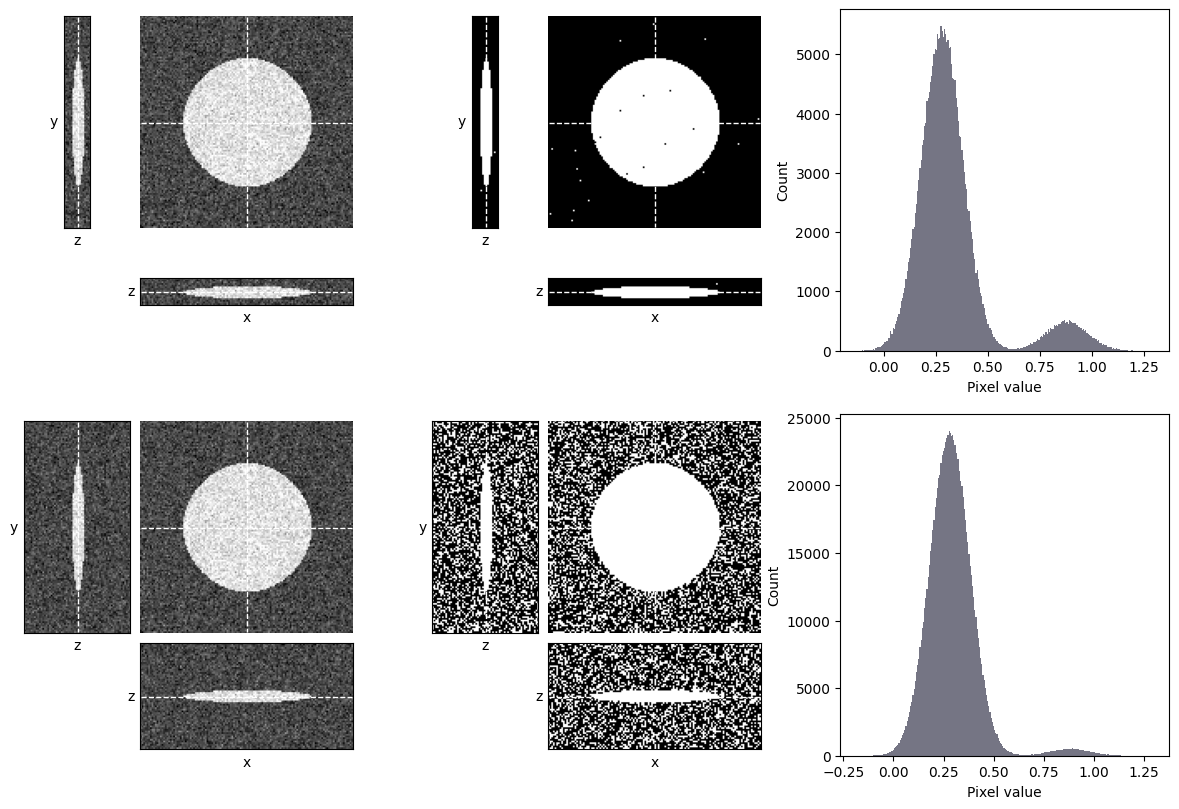

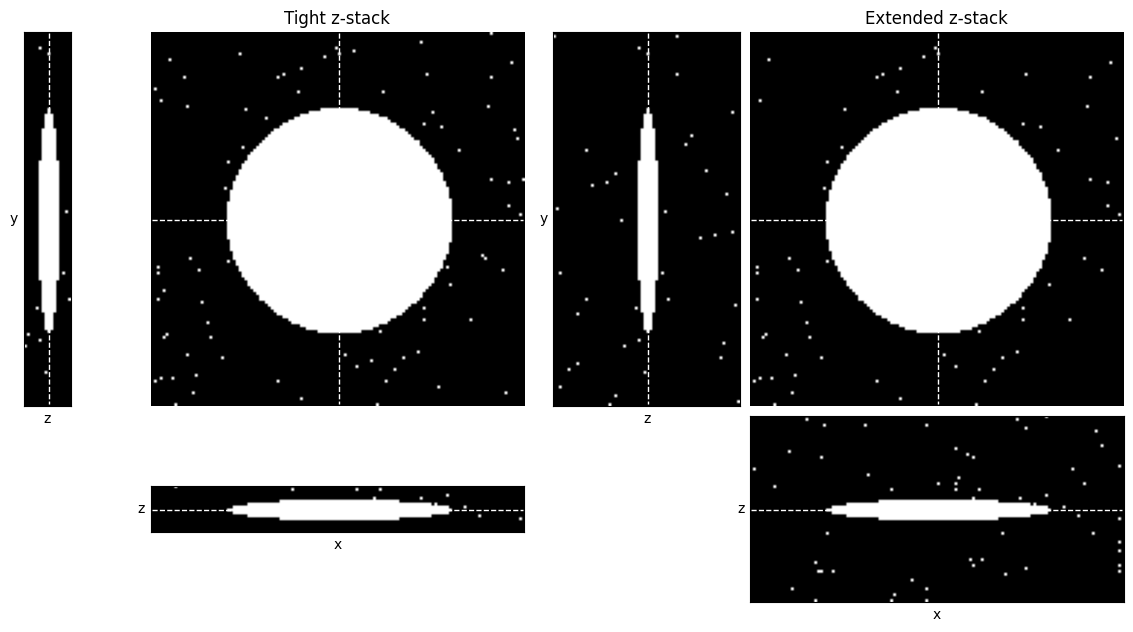

In [2]:
im = np.zeros((64, 128, 128))
im[32, 64, 64] = 1.0
im = ndimage.gaussian_filter(im, sigma=(3, 32, 32))
im = np.expand_dims(im, axis=-1)
im = (im > im.max()/2).astype(np.float32) * 6
im = im + np.random.default_rng(100).normal(size=im.shape)

# Convert to float32 and rescale per channel (to simplify display later)
im = im.astype(np.float32)
for c in range(im.shape[-1]):
    im[..., c] = im[..., c] - np.percentile(im[..., ], 0.25)
    im[..., c] = im[..., c] / np.percentile(im[..., ], 99.75)

def show_orthogonal(im, axes, loc=None, projection=None, colors=None, show_slices=False, title=None):
    """
    Show orthogonal slices or projections.
    """
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    n_channels = im.shape[-1] if im.ndim > 3 else 1
    if colors is None:
        if n_channels == 1:
            colors = ('white',)
        elif n_channels == 2:
            colors = ('green', 'magenta')
        elif n_channels == 3:
            colors = ('red', 'green', 'blue')
        else:
            raise ValueException('Colors must be specified if the number of channels is > 3!')

    if axes is None:
        fig = create_figure()
        ax = fig.gca()
    else:
        ax = axes

    if loc is None and projection is None:
        loc = tuple(s//2 for s in im.shape)

    # Create axes for orthogonal views
    divider = make_axes_locatable(ax)
    ax_xz = divider.append_axes("bottom", size="50%", pad=0.1, sharex=ax)
    ax_yz = divider.append_axes("left", size="50%", pad=0.1, sharey=ax)

    # Generate slices or projections
    if projection:
        imxy = projection(im, axis=0)
        imxz = projection(im, axis=2)
        imyz = np.moveaxis(projection(im, axis=1), 0, 1)
    else:
        imxy = im[loc[0],...]
        imxz = im[:, loc[1],...]
        imyz = np.moveaxis(im[:, :, loc[2],:], 0, 1)


    show_image(create_rgb(imyz, colors),
                   axes=ax_yz, vmin=0, vmax=1)
    if show_slices:
        ax_yz.plot([loc[0], loc[0]], [0, im.shape[2]-1], 'w--', linewidth=1)
    ax_yz.set_xlabel('z')
    ax_yz.set_xticks([])
    ax_yz.set_ylabel('y', rotation=0, va='center', ha='right')
    ax_yz.set_yticks([])
    ax_yz.set_axis_on()

    show_image(create_rgb(imxy, colors),
                   axes=ax,
                   vmin=0, vmax=1)
    if show_slices:
        row = loc[1]
        col = loc[2]
        ax.plot([0, im.shape[1]-1], [row, row], 'w--', linewidth=1)
        ax.plot([col, col], [0, im.shape[2]-1], 'w--', linewidth=1)

    show_image(create_rgb(imxz, colors),
                   axes=ax_xz,
                   vmin=0, vmax=1)
    if show_slices:
        ax_xz.plot([0, im.shape[1]-1], [loc[0], loc[0]], 'w--', linewidth=1)
    ax_xz.set_xlabel('x')
    ax_xz.set_xticks([])
    ax_xz.set_ylabel('z', rotation=0, va='center', ha='right')
    ax_xz.set_yticks([])
    ax_xz.set_axis_on()

    plt.tight_layout()

    if title:
        ax.set_title(title)


im = np.expand_dims(im, axis=-1)
im = im[..., 0]
im_tight = im[24:-24, ...]

fig, axes = plt.subplots(2, 3, figsize=(12, 8))

from skimage.filters import threshold_triangle, threshold_otsu

show_orthogonal(im_tight, show_slices=True, axes=axes[0, 0])
show_orthogonal(im_tight > threshold_otsu(im_tight), show_slices=True, axes=axes[0, 1])
show_histogram(im_tight, bins=256, axes=axes[0, 2])

show_orthogonal(im, show_slices=True, axes=axes[1, 0])
show_orthogonal(im > threshold_otsu(im), show_slices=True, axes=axes[1, 1])
show_histogram(im, bins=256, axes=axes[1, 2])

glue_fig('fig_multi_thresholds', fig)

## Create another figure for the question below
bw_tight_triangle = im_tight > threshold_triangle(im_tight)
bw_triangle = im > threshold_triangle(im)

fig, axes = plt.subplots(1, 2, figsize=(12, 8))
show_orthogonal(bw_tight_triangle, title='Tight z-stack', show_slices=True, axes=axes[0])
show_orthogonal(bw_triangle, title='Extended z-stack', show_slices=True, axes=axes[1])

glue_fig('fig_multi_thresholds_triangle', fig)

```{glue:figure} fig_multi_thresholds
---
align: center
name: fig-multi_thresholds
---

Thresholding a z-stack can be influenced by the number of out-of-focus slices. Here, an automated threshold determined using [Otsu's method](sec_thresholds_otsu) is applied to two z-stacks showing the same object. The top stack contains few out-of-focus slices, while the bottom stack contains the exact same data plus additional slices that contain only noise. Otsu's method is well-suited to the top stack and performs well, however it fails badly on the bottom stack, where there is a much higher proportion of background pixels -- and so the background peak is more dominant.
```

`````{tab-set}

````{tab-item} Question
How would you expect {numref}`fig-multi_thresholds` to differ if the [triangle method](sec_thresholds_triangle) was used to determine the threshold, rather than [Otsu's method](sec_thresholds_otsu)?
````

````{tab-item} Answer
Here, the triangle method performs well.
It sets the threshold appropriately at the foot of the background peak in both cases.

```{glue:figure} fig_multi_thresholds_triangle
---
align: center
---
```

````
`````

### Filtering

**Linear filters** can be easily extended to *nD* by defining a filter kernel with the desired number of dimensions.
However, this can dramatically increase the computational requirements and so we need to begin considering performance.

For example, suppose we have a 3×3 filter.
Following the algorithm for linear filtering [described previously](sec_filters_linear), we would have to perform 9 multiplications and additions to determine the value for *every* pixel in the output image.
If our image is 1000×1000 pixels in size, that suggests 9,000,000 multiplications and additions.
This seems quite a lot, but modern computers are fast so we're unlikely to notice it.

However, if we have a 3×3×3 filter then each output pixel depends upon 27 input pixels.
And the additional slices mean our image is likely to be bigger; say, 1000×1000×10 pixels.
Now we have to perform calculations involving 270,000,000 pixels, i.e. a lot more.
Still, even that is probably fast nowadays.

But how big can we go?
An 11×11 filter involves 121 pixels.
But an 11×11×11 filter involves 1331.
For larger filters and images, we can rapidly increase the computations involved until processing *is* very slow.

The situation improves *dramatically* if a filter is **separable**.
This means that instead of applying, for example, a single 11×11×11 filter (1331 coefficients) we can instead apply three separate 11×1 filters oriented along each dimension (33 coefficients).

Not all linear filters are separable, but many common ones are.
This includes mean filters (depending upon neigborhood shape) and Gaussian filters.
The result of applying the filter separably should be the same as the result of applying one dense multidimensional filter ({numref}`fig-gauss_separable`).
Some small differences may arise through the handling of [rounding and bit-depths](chap_bit_depths), but the improvement in performance is almost certainly worth any tiny error introduced by applying a filter separably.

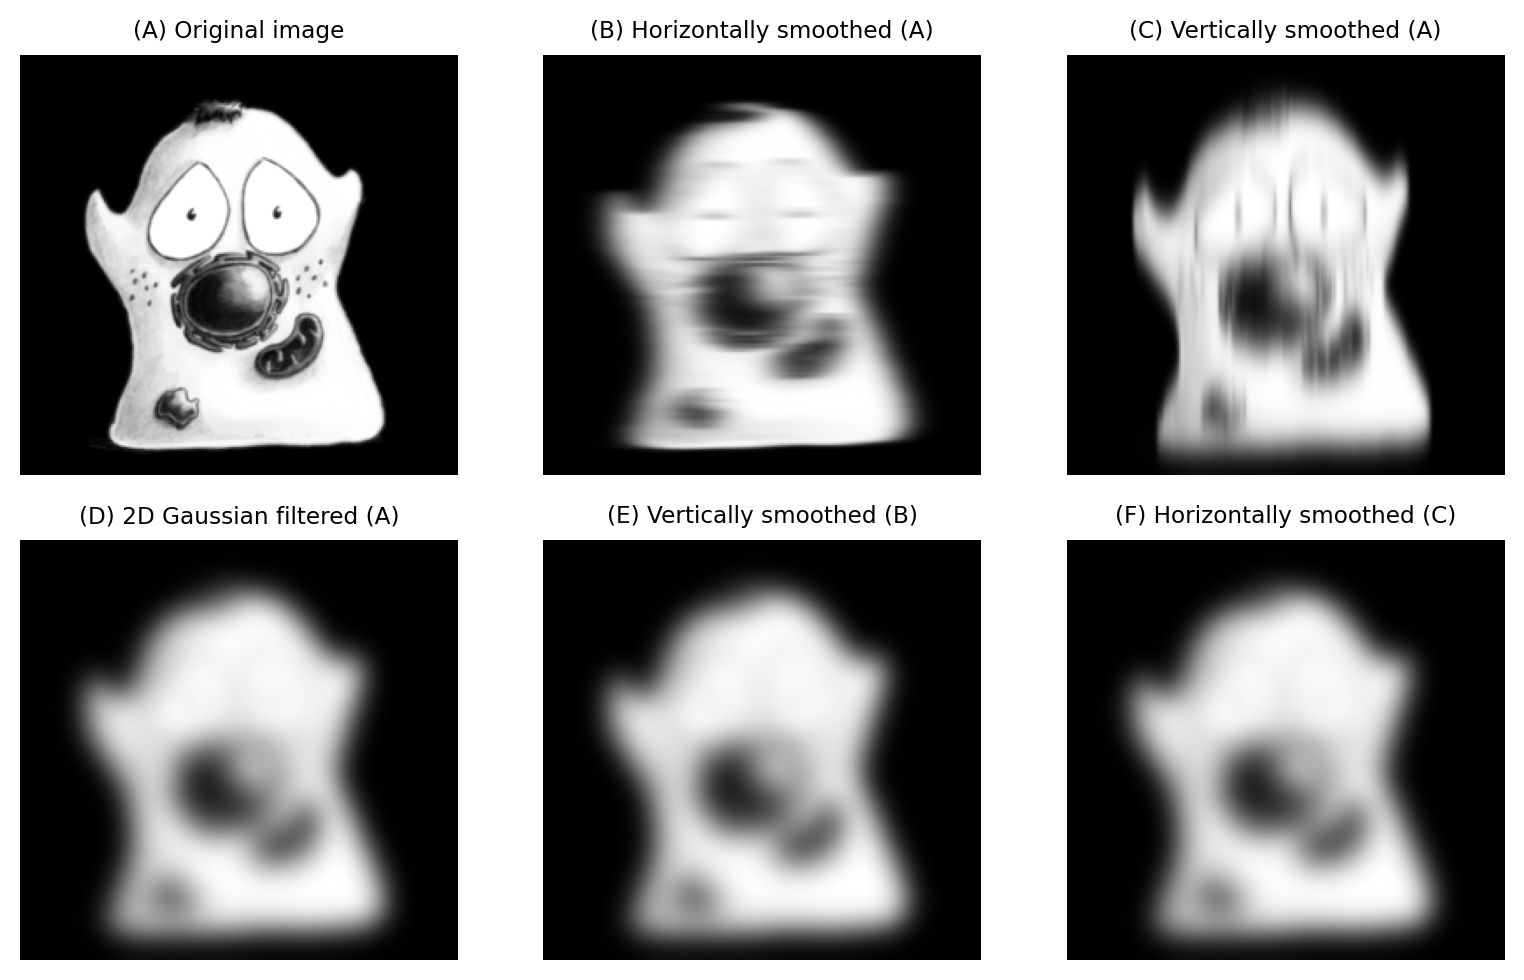

In [3]:
"""
Demonstrate how Gaussian filters may be separable.
"""

fig = create_figure(figsize=(8, 5))

import numpy as np
from scipy import ndimage

im = load_image('happy_cell.tif').astype(np.float32)

sigma = 8

show_image(im, title="(A) Original image", pos=231)

# Filter horizontally, then vertically
im_h = ndimage.gaussian_filter1d(im, sigma, axis=1)
show_image(im_h, title="(B) Horizontally smoothed (A)", pos=232)

# Filter vertically, then horizontally
im_v = ndimage.gaussian_filter1d(im, sigma, axis=0)
show_image(im_v, title="(C) Vertically smoothed (A)", pos=233)

# Admission... the docs for gaussian_filter state that it's implemented separably -
# so this doesn't really demonstrate that 2D filtering is the same
# (except inasmuch as ndimage treats them equivalently)
im_gauss = ndimage.gaussian_filter(im, sigma)
show_image(im_gauss, title="(D) 2D Gaussian filtered (A)", pos=234)

im_hv = ndimage.gaussian_filter1d(im_h, sigma, axis=0)
show_image(im_hv, title="(E) Vertically smoothed (B)", pos=235)

im_vh = ndimage.gaussian_filter1d(im_v, sigma, axis=1)
show_image(im_vh, title="(F) Horizontally smoothed (C)", pos=236)

plt.tight_layout()
glue_fig('fig_gauss_separable', fig)

```{glue:figure} fig_gauss_separable
---
align: center
name: fig-gauss_separable
---

2D Gaussian smoothing can be applied using a single 2D filter, or by sequentially filtering either rows or columns of the image: the end result is the same (up to rounding error). The order of the separable filtering doesn't matter.
```

Considerations are similar for **nonlinear filters**: when we add more dimensions, the neighborhood size can increase quickly and make the calculations slow.
Separability can help with some nonlinear filters (e.g. minimum and maximum, depending on window shape), but not all.
Median filters in particular are difficult to optimize, and can be *extremely* slow when the neighborhood is large and/or more than 2D.

:::{admonition} Isotropy and anisotropy
:class: warning

As discussed {ref}`chap_pixel_size`, the pixel width and height are usually the same.
For a *z*-stack, the *z*-spacing *might* be the same as the width and height, in which case the pixels are called **isotropic**.
But very often the *z*-spacing is different, meaning that the pixels are **anisotropic**.

It helps to keep this in mind when choosing filter sizes.
For example, I would usually set the $\sigma$ value for a 3D Gaussian filter based upon the pixel size.

Suppose that the pixel width and height are both 0.5 µm, and the *z*-spacing is 1 µm.
I might then choose $\sigma_x$ = 2 px, $\sigma_y$ = 2 px and $\sigma_z$ = 1 px to compensate for the difference.

Note that some software may allow you to enter the $\sigma$ in µm directly, and perform the conversion to pixels automatically.
:::

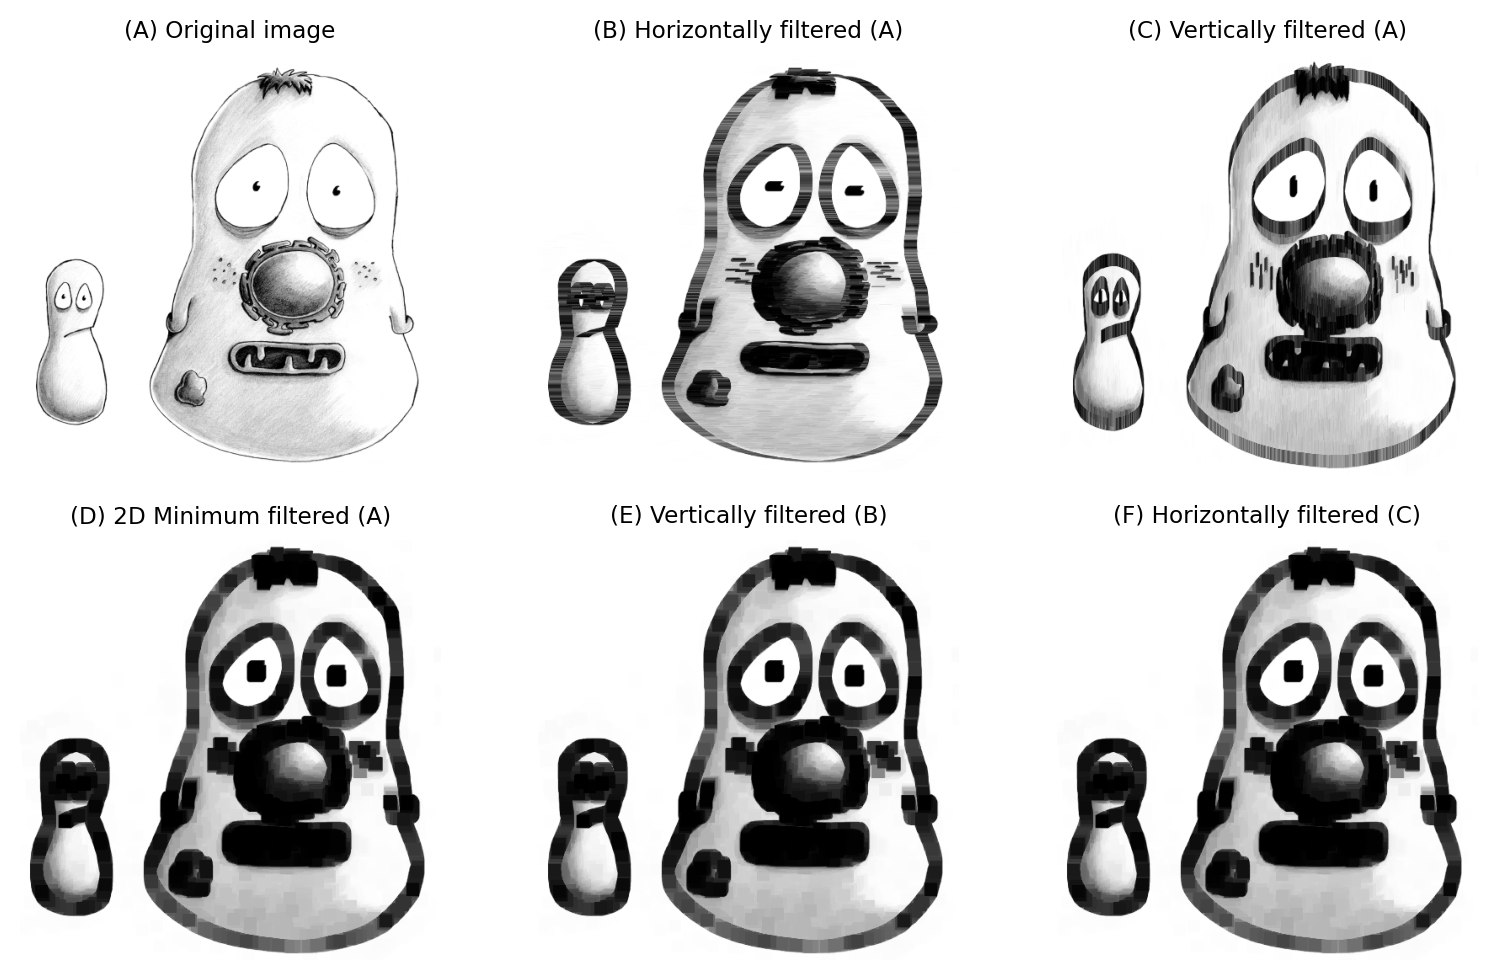

In [4]:
"""
Demonstrate how minimum filters may be separable.
"""

fig = create_figure(figsize=(8, 5))

import numpy as np
from scipy import ndimage

im = load_image('fixed_cells.png')
# im = load_image('happy_cell.tif')

size = 15

show_image(im, title="(A) Original image", pos=231)

# Filter horizontally, then vertically
im_h = ndimage.minimum_filter1d(im, size, axis=1)
show_image(im_h, title="(B) Horizontally filtered (A)", pos=232)

# Filter vertically, then horizontally
im_v = ndimage.minimum_filter1d(im, size, axis=0)
show_image(im_v, title="(C) Vertically filtered (A)", pos=233)

im_gauss = ndimage.minimum_filter(im, (size, size))
show_image(im_gauss, title="(D) 2D Minimum filtered (A)", pos=234)

im_hv = ndimage.minimum_filter1d(im_h, size, axis=0)
show_image(im_hv, title="(E) Vertically filtered (B)", pos=235)

im_vh = ndimage.minimum_filter1d(im_v, size, axis=1)
show_image(im_vh, title="(F) Horizontally filtered (C)", pos=236)

plt.tight_layout()
glue_fig('fig_multi_min_separable', fig)

```{glue:figure} fig_multi_min_separable
---
align: center
name: fig-multi_min_separable
---

A 15×15 minimum filter applied separably.
```

### Morphological operations

Erosion, dilation, opening and closing can all be implemented using minimum and maximum nonlinear filters, so the above considerations apply.
Morphological reconstruction can also work in *nD*.
Therefore all the new operations and tricks derived from these methods (e.g. creating outlines, finding regional maxima) should work.

Thinning algorithms are often designed to work in 3D, although not usually higher dimensions.

### Image transforms

The distance and watershed transforms extend readily to 3D, but require a little caution.

One thing to look out for, especially with the distance transform, is whether pixel anisotropy is taken into consideration.
If not, the the distance transform will not be capable of properly identifying the 'nearest' foreground or background pixel in calibrated units, but rather only in pixel units.

A cumbersome workaround may be to resize the image so that the pixels *are* isotropic, but that may make every other analysis step more complicated and/or require a huge amount more memory to store the image.
A preferable approach is to try to find a distance transform implementation that incorporates pixel size information into its calculations.

## Accelerating analysis

One of the common themes of processing multidimensional images is performance.

Even though *conceptually* most of the image processing techniques we've discussed can be extended to 3D and beyond, it's usually not easy to do from the programmer's perspective.
As someone who writes software, I can attest that I don't tend to support more dimensions than I have to because extra dimensions make the task of coding, debugging and optimizing much, much harder.

'Optimizing' really matters because, as mentioned above, computational requirements can increase quickly and dramatically with multidimensional data.
That doesn't just mean the software itself needs to be optimized to run fast: the user plays a huge role in choosing what they ask the software to do.
Keep in mind:

:::{admonition} The most important performance consideration is the algorithm!
:class: tip

Before investing in a bigger computer to try to speed up a slow analysis workflow, look for ways to make it more efficient without compromising accuracy.

For example, do you really need to apply a 49×49×49 pixel filter to a large image, at a cost of 117,649 multiplications & additions for *every pixel*?
If a separable filter can be used instead, you can shrink that figure to 147 (~0.12%).
Perhaps the calculation can also be performed on a lower resolution image, saving even more effort.

Alternatively, if you find you're applying large minimum or maximum filters to a binary image, perhaps you could instead use a [distance transform for erosion and dilation](fig-morph_distance).

When processing is slow, it's worth trying to get the computer to work smarter, not harder.
:::

Nevertheless, there comes a time when better hardware really can help -- assuming the software can take advantage of it.

Most modern computers capable of image analysis contain multiple processors, which can do multiple things at the same time.
Image analysis software that supports **multiprocessing** is able to use these processors to operate on different parts of the data simultaneously.
It's more work for the programmer, but better for the user.

The benefits of multiprocessing can be important, but still tend to be fairly modest.
A typical desktop computer today could have between 2 and 8 processors (although particularly powerful machines can have more).
However, doubling the numbers of processors doesn't mean that the computation time is likely to be halved, because it's hard for software to keep all the processors occupied.
Tasks tend to depend upon one another, and so it's common for one processor to have to lounge around while another processor is completing its part of the job.
Our performance aspirations can also be thwarted by other bottlenecks, such as reading or writing images.

To see a **dramatic** improvement in image processing performance, we usually need to look into **Graphics Processing Unit (GPUs)**, aka. **graphics cards**.

A GPU can't do everything that a general-purpose processor can do, but it is very good at what it *can* do -- which includes core operations like image filtering or matrix multiplication.

```{margin}
Haase, R., Royer, L.A., Steinbach, P. et al. CLIJ: GPU-accelerated image processing for everyone. *Nat Methods* 17, 5–6 (2020). [(DOI)](https://doi.org/10.1038/s41592-019-0650-1)
```

Programming for GPUs is rather specialized, but there are some tools to help.
**Robert Haase** has worked extensively on using GPUs for multidimensional bioimage analysis -- I highly recommend checking out [**CLIJ**](https://clij.github.io/) and [**clEsperanto**](https://clesperanto.github.io) for more details.